# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


from time import time
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pydotplus
import collections

from tqdm import tqdm
import os

D:\Program Files(C)\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('D:/Machine Learning Notes/Python Notebook/Amazon Fine Food Reviews Analysis/database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 46071/46071 [00:31<00:00, 1458.71it/s]


In [24]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.
# Combining all the above stundents 
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

 75%|███████████████████████████████████████████████████████▋                  | 34693/46071 [00:16<00:05, 2261.46it/s]D:\Program Files(C)\Anaconda\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████████████████████████████████████████████████████████████████████| 46071/46071 [00:22<00:00, 2093.36it/s]


### [4.3]. Split Dataset into Train and Test

In [26]:
from sklearn import model_selection as ms
y=final['Score'][:50000]
dw_train,dw_test,y_train,y_test=ms.train_test_split(preprocessed_reviews, y, stratify=y, test_size=0.3, random_state=0)

# [4] Featurization

## [4.1] BAG OF WORDS

In [26]:
#BoW
count_vect = CountVectorizer(dtype='float') #in scikit-learn
d_train =count_vect.fit_transform(dw_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand', 'aaah']


In [27]:
print("the type of count vectorizer ",type(d_train))
print("the shape of train-text BOW vectorizer ",d_train.get_shape())

d_test = count_vect.transform(dw_test)
print("the shape of test-text BOW vectorizer ",d_test.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (32249, 33270)
the shape of test-text BOW vectorizer  (13822, 33270)


## [4.2] Bi-Grams and n-Grams.

In [28]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect_gram = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
d_train_gram = count_vect_gram.fit_transform(dw_train)


In [29]:
#Vectorize cv and test data
print("the type of count vectorizer ",type(d_train_gram))
print("the shape of train-text BOW vectorizer ",d_train_gram.get_shape())

d_test_gram = count_vect_gram.transform(dw_test)
print("the shape of test-text BOW vectorizer ",d_test_gram.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (32249, 5000)
the shape of test-text BOW vectorizer  (13822, 5000)


## [4.3] TF-IDF

In [30]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
d_train_tf =tf_idf_vect.fit_transform(dw_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able figure', 'able find', 'able get']


In [31]:
#Vectorize cv and test data
print("the type of count vectorizer ",type(d_train_tf))
print("the shape of train-text BOW vectorizer ",d_train_tf.get_shape())

d_test_tf = tf_idf_vect.transform(dw_test)
print("the shape of test-text BOW vectorizer ",d_test_tf.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (32249, 19259)
the shape of test-text BOW vectorizer  (13822, 19259)


## [4.4] Word2Vec

In [29]:
# Train your own Word2Vec model using your own text corpus
train_list=[]
test_list=[]
for sent in dw_train:
    train_list.append(sent.split())
for sent in dw_test:
    test_list.append(sent.split())

In [31]:
# Using Google News Word2Vectors
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(train_list,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8931759595870972), ('fantastic', 0.81374192237854), ('good', 0.7949845194816589), ('excellent', 0.7934795618057251), ('wonderful', 0.7878952026367188), ('amazing', 0.7727926969528198), ('terrific', 0.7660394906997681), ('perfect', 0.7404593229293823), ('nice', 0.6787368059158325), ('decent', 0.6542344093322754)]
[('nastiest', 0.7353682518005371), ('best', 0.7282435894012451), ('greatest', 0.7013878226280212), ('closest', 0.6816176176071167), ('tastiest', 0.6804839372634888), ('awful', 0.6594173908233643), ('disgusting', 0.6506674289703369), ('experienced', 0.649543285369873), ('saltiest', 0.6463325023651123), ('smoothest', 0.6412044763565063)]


In [32]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10791
sample words  ['delivered', 'quickly', 'bought', 'grain', 'free', 'dog', 'however', 'not', 'care', 'think', 'kibble', 'rather', 'small', 'aroma', 'salmon', 'based', 'foods', 'donating', 'remainder', 'animal', 'rescue', 'group', 'baby', 'likes', 'smells', 'delicious', 'seem', 'stain', 'thin', 'cereal', 'needs', 'added', 'overall', 'good', 'highly', 'recommended', 'looking', 'cracker', 'daughter', 'put', 'gfcf', 'diet', 'glutino', 'close', 'normal', 'come', 'across', 'rest', 'us', 'even']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [35]:
# average Word2Vec
# compute average word2vec for each review in train dataset.
#train dataset
d_train_w2 = [];
for sent in tqdm(train_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    d_train_w2.append(sent_vec)
print(len(d_train_w2))
print(len(d_train_w2[0]))

100%|██████████| 32249/32249 [00:55<00:00, 579.99it/s]

32249
50


In [36]:
# average Word2Vec
# compute average word2vec for each review in test dataset.
#test dataset
d_test_w2 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(test_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    d_test_w2.append(sent_vec)
print(len(d_test_w2))
print(len(d_test_w2[0]))


100%|██████████| 13822/13822 [00:24<00:00, 564.80it/s]

13822
50


#### [4.4.1.2] TFIDF weighted W2v

In [27]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(dw_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

d_train_tf_wt = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(train_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    d_train_tf_wt.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 32249/32249 [16:32<00:00, 32.49it/s]


In [34]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

#test dataset
d_test_tf_wt = [];
row=0;
for sent in tqdm(test_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    d_test_tf_wt.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 13822/13822 [07:22<00:00, 31.23it/s]


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [35]:
# Please write all the code with proper documentation
def cv_DT(d_train, y_train):
    import warnings
    warnings.filterwarnings('ignore')

    #defining 'alpha' for grid-search alpha = 1/C
    param= {'max_depth':[1,5,10,50,100,500,1000],'min_samples_split':[5,10,100,500]}

    #Using Grid Search to get optimal number of estimators and maximum depth
    start = time()
    #instatiate the model
    clfDT = DecisionTreeClassifier(class_weight='balanced')
    clf = GridSearchCV(clfDT, param, cv=5,scoring='roc_auc')
    clf.fit(d_train, y_train)
    print("Time elapsed : %.2f Seconds" % (time() - start))
    print(" optimal alpha using Grid Search is " + str(clf.best_params_))
    optimal_max_depth=clf.best_params_.get('max_depth')
    optimal_min_samples_split=clf.best_params_.get('min_samples_split')
    return optimal_max_depth,optimal_min_samples_split

In [36]:
#plot confusion matrix and print report
def report(x,y,model):
    y_true, y_pred = y, model.predict(x)
    print(classification_report(y_true, y_pred))
    print()
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print("The value of TPR is %.3f" %(tp/(fn+tp)) +
          "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
         "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
         "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
         
    cm=confusion_matrix(y_true, y_pred)
    ax=sns.heatmap(cm,annot=True,fmt="d")
    ax.set(xlabel='Predicted', ylabel='Actual')
    print()
    print("The roc auc score is %f" %roc_auc_score(y_true, model.predict_proba(x)[:,1]))

In [37]:
def plotROC(d_trai,y_trai,d_tes,y_tes,clf):
    train_score = clf.predict_proba(d_trai)[:,1]
    test_score = clf.predict_proba(d_tes)[:,1]
    fpr_train, tpr_train, _ = roc_curve(y_trai, train_score)
    fpr_test, tpr_test, _ = roc_curve(y_tes, test_score)
    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)
    plt.title('Receiver Operating Characteristic Curve')
    plt.plot(fpr_train, tpr_train, label = 'AUC Train = %0.2f' % auc_train)
    plt.plot(fpr_test, tpr_test, label = 'AUC Test = %0.2f' % auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [42]:
#calculating auc score for train and test dataset
max_depth = [1,5,10,50,100,500,1000]
min_samples_split = [5,10,100,500]
def calculateAUCScore(d_trai,y_trai,d_tes,y_tes):
    auc_train_list=list()
    auc_test_list=list()
    for i in max_depth:
        for j in min_samples_split:
            model = DecisionTreeClassifier(max_depth= i , min_samples_split = j ,class_weight='balanced')
            model.fit(d_trai,y_trai)
            train_score = model.predict_proba(d_trai)[:,1]
            test_score = model.predict_proba(d_tes)[:,1]
            fpr_train, tpr_train, _ = roc_curve(y_trai, train_score)
            fpr_test, tpr_test, _ = roc_curve(y_tes, test_score)
            auc_train_list.append(auc(fpr_train, tpr_train))
            auc_test_list.append(auc(fpr_test, tpr_test))
    return auc_train_list,auc_test_list

In [39]:
def plotHeatMap(d_trai,y_trai,d_tes,y_tes):
    listTemp= list(calculateAUCScore(d_trai,y_trai,d_tes,y_tes))
    name=["HeatMap on Train Data", "HeatMap on Test Data"]
    for z in range(2):
        k=0
        #creating dataframe with empty cells
        df=pd.DataFrame([],columns =[5,10,100,500],index=[1,5,10,50,100,500,1000])
        #populating dataframe cells by auc scores
        for i in max_depth:
            for j in min_samples_split:
                df.at[i,j]=listTemp[z][k]
                k+=1
        #changing datatype of cells from NaN to float
        df = df.apply(pd.to_numeric, axis=1)
        ax=sns.heatmap(df,annot=True,fmt="f")
        ax.set(xlabel='Max Depth', ylabel='Min Samples Split',title=name[z])
        plt.show()
        #print("")

In [45]:
omd_bow,omss_bow = cv_DT(d_train, y_train)

Time elapsed : 778.12 Seconds
 optimal alpha using Grid Search is {'max_depth': 50, 'min_samples_split': 500}


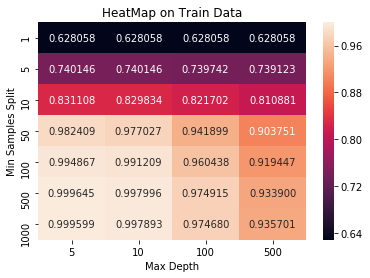

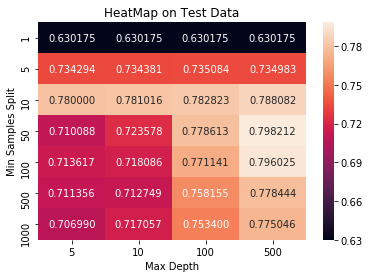

In [46]:
#plot heatmap on train and test data
plotHeatMap(d_train,y_train,d_test,y_test)

In [47]:
#model with optimal max_depth and optimal min_samples_split
dt_bow=DecisionTreeClassifier(max_depth= omd_bow , min_samples_split = omss_bow,class_weight='balanced')
dt_bow.fit(d_train,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

              precision    recall  f1-score   support

           0       0.42      0.88      0.57      5314
           1       0.97      0.76      0.85     26935

   micro avg       0.78      0.78      0.78     32249
   macro avg       0.69      0.82      0.71     32249
weighted avg       0.88      0.78      0.80     32249


The value of TPR is 0.759
The value of TNR is 0.876
The value of FPR is 0.124
The value of FNR is 0.241

The roc auc score is 0.904505


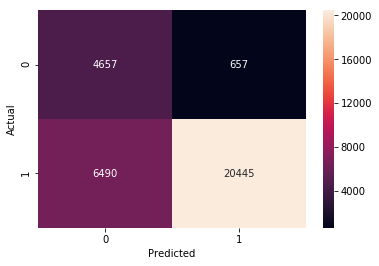

In [48]:
#report on train data
report(d_train,y_train,dt_bow)

              precision    recall  f1-score   support

           0       0.36      0.75      0.48      2278
           1       0.94      0.73      0.82     11544

   micro avg       0.74      0.74      0.74     13822
   macro avg       0.65      0.74      0.65     13822
weighted avg       0.84      0.74      0.77     13822


The value of TPR is 0.734
The value of TNR is 0.748
The value of FPR is 0.252
The value of FNR is 0.266

The roc auc score is 0.799814


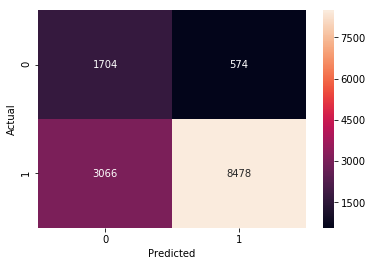

In [49]:
#report on test data
report(d_test,y_test,dt_bow)

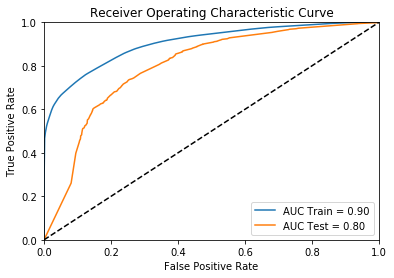

In [50]:
#plot roc curve for train and test data
plotROC(d_train,y_train,d_test,y_test,dt_bow)

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [51]:
# Please write all the code with proper documentation
feature_names = count_vect.get_feature_names() #getting feature names
#getting feature importance
arr=dt_bow.feature_importances_
#binding feature importance and names
pos = sorted(zip(arr, feature_names))
words=list()
for i in pos:
    words.append(i[1])
print("Top 20 important features are : \n",words[-20:])

Top 20 important features are : 
 ['disappointing', 'highly', 'terrible', 'thought', 'worst', 'wonderful', 'excellent', 'horrible', 'nice', 'favorite', 'bad', 'loves', 'good', 'perfect', 'disappointed', 'love', 'delicious', 'best', 'great', 'not']


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [52]:
# Please write all the code with proper documentation
#creating graph of the tree
#reference from this blog : https://pythonprogramminglanguage.com/decision-tree-visual-example/ to save as .png image
expo_graph = export_graphviz(dt_bow,feature_names=feature_names,max_depth = 2, filled=True,rounded=True) #creating graph using graphviz
graph = pydotplus.graph_from_dot_data(expo_graph)

colors = ('magenta', 'yellow')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('Bow_Tree.png') #creating and saving graph as image 

True

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [53]:
# Please write all the code with proper documentation
omd_tf,omss_tf = cv_DT(d_train_tf, y_train)

Time elapsed : 954.48 Seconds
 optimal alpha using Grid Search is {'max_depth': 50, 'min_samples_split': 500}


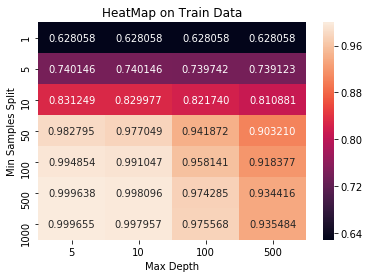

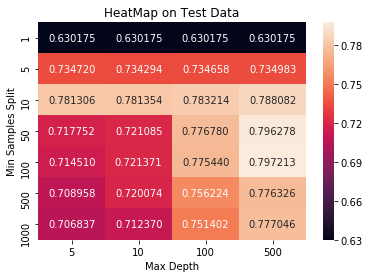

In [54]:
#plot heatmap on train and test data
plotHeatMap(d_train_tf,y_train,d_test_tf,y_test)

In [55]:
#model with optimal max_depth and optimal min_samples_split
dt_tf=DecisionTreeClassifier(max_depth= omd_tf , min_samples_split = omss_tf,class_weight='balanced')
dt_tf.fit(d_train_tf,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

              precision    recall  f1-score   support

           0       0.43      0.90      0.58      5314
           1       0.97      0.76      0.86     26935

   micro avg       0.78      0.78      0.78     32249
   macro avg       0.70      0.83      0.72     32249
weighted avg       0.88      0.78      0.81     32249


The value of TPR is 0.762
The value of TNR is 0.900
The value of FPR is 0.100
The value of FNR is 0.238

The roc auc score is 0.914116


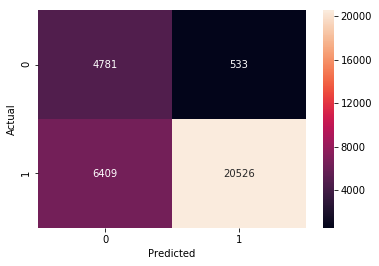

In [56]:
#report on train data
report(d_train_tf,y_train,dt_tf)

              precision    recall  f1-score   support

           0       0.36      0.75      0.49      2278
           1       0.94      0.74      0.82     11544

   micro avg       0.74      0.74      0.74     13822
   macro avg       0.65      0.74      0.66     13822
weighted avg       0.84      0.74      0.77     13822


The value of TPR is 0.735
The value of TNR is 0.752
The value of FPR is 0.248
The value of FNR is 0.265

The roc auc score is 0.803005


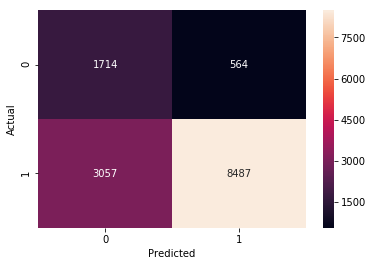

In [57]:
#report on test data
report(d_test_tf,y_test,dt_tf)

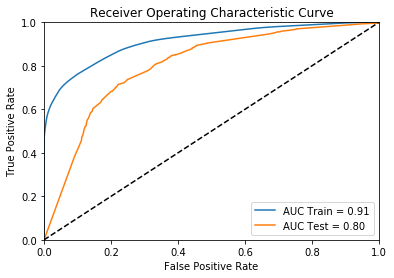

In [58]:
#plot roc curve for train and test data
plotROC(d_train_tf,y_train,d_test_tf,y_test,dt_tf)

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [59]:
# Please write all the code with proper documentation
feature_names_tf = tf_idf_vect.get_feature_names() #getting feature names
#getting feature importance
arr=dt_bow.feature_importances_
#binding feature importance and names
pos = sorted(zip(arr, feature_names_tf))
words=list()
for i in pos:
    words.append(i[1])
print("Top 20 important features are : \n",words[-20:])

Top 20 important features are : 
 ['whatever want', 'never found', 'eat eat', 'like sour', 'brush teeth', 'buddy', 'baby formula', 'italy', 'rate', 'mash', 'recommend anybody', 'much else', 'buy bags', 'think tea', 'pay attention', 'issues not', 'think one', 'health benefits', 'chipotle', 'plan use']


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [60]:
# Please write all the code with proper documentation
#creating graph of the tree
#reference from this blog : https://pythonprogramminglanguage.com/decision-tree-visual-example/ for saving the image
expo_graph_tf = export_graphviz(dt_tf,feature_names=feature_names_tf,max_depth = 2, filled=True,rounded=True) #creating graph using graphviz
graph_tf = pydotplus.graph_from_dot_data(expo_graph_tf)

colors = ('green', 'yellow')
edges = collections.defaultdict(list)

for edge in graph_tf.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph_tf.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph_tf.write_png('TFIdf_Tree.png') #creating and saving graph as image 

True

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [61]:
# Please write all the code with proper documentation
omd_w2,omss_w2 = cv_DT(d_train_w2, y_train)

Time elapsed : 194.12 Seconds
 optimal alpha using Grid Search is {'max_depth': 10, 'min_samples_split': 500}


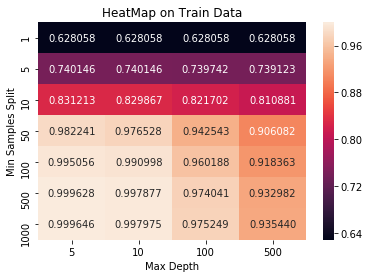

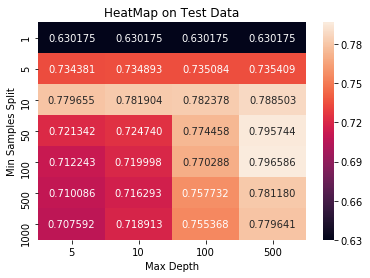

In [62]:
#plot heatmap on train and test data
plotHeatMap(d_train_w2,y_train,d_test_w2,y_test)

In [63]:
#model with optimal max_depth and optimal min_samples_split
dt_w2=DecisionTreeClassifier(max_depth= omd_w2 , min_samples_split = omss_w2,class_weight='balanced')
dt_w2.fit(d_train_w2,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

              precision    recall  f1-score   support

           0       0.39      0.81      0.53      5314
           1       0.95      0.75      0.84     26935

   micro avg       0.76      0.76      0.76     32249
   macro avg       0.67      0.78      0.69     32249
weighted avg       0.86      0.76      0.79     32249


The value of TPR is 0.753
The value of TNR is 0.809
The value of FPR is 0.191
The value of FNR is 0.247

The roc auc score is 0.865265


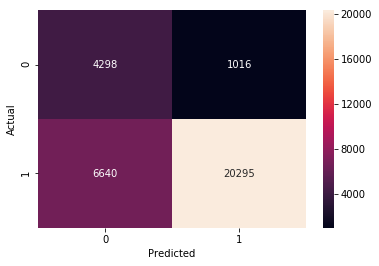

In [64]:
#report on train data
report(d_train_w2,y_train,dt_w2)

              precision    recall  f1-score   support

           0       0.37      0.76      0.50      2278
           1       0.94      0.74      0.83     11544

   micro avg       0.74      0.74      0.74     13822
   macro avg       0.65      0.75      0.66     13822
weighted avg       0.85      0.74      0.77     13822


The value of TPR is 0.740
The value of TNR is 0.764
The value of FPR is 0.236
The value of FNR is 0.260

The roc auc score is 0.831429


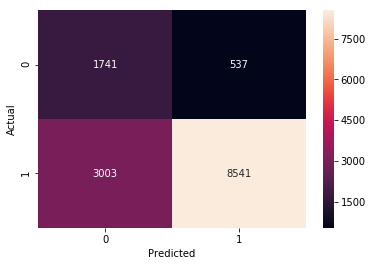

In [65]:
#report on test data
report(d_test_w2,y_test,dt_w2)

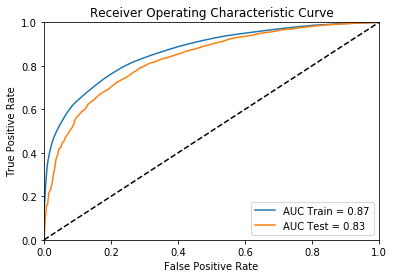

In [66]:
#plot roc curve for train and test data
plotROC(d_train_w2,y_train,d_test_w2,y_test,dt_w2)

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [40]:
# Please write all the code with proper documentation
omd_tf_wt,omss_tf_wt = cv_DT(d_train_tf_wt, y_train)

Time elapsed : 288.27 Seconds
 optimal alpha using Grid Search is {'max_depth': 10, 'min_samples_split': 500}


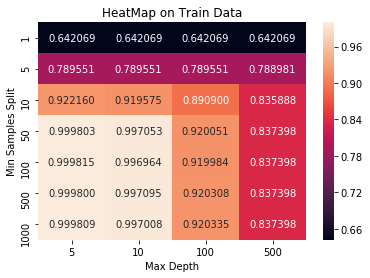

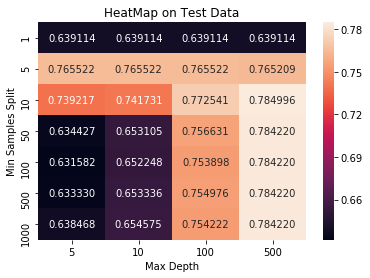

In [43]:
#plot heatmap on train and test data
plotHeatMap(d_train_tf_wt,y_train,d_test_tf_wt,y_test)

In [44]:
#model with optimal max_depth and optimal min_samples_split
dt_tf_wt=DecisionTreeClassifier(max_depth= omd_tf_wt , min_samples_split = omss_tf_wt,class_weight='balanced')
dt_tf_wt.fit(d_train_tf_wt,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

              precision    recall  f1-score   support

           0       0.35      0.81      0.48      5314
           1       0.95      0.70      0.81     26935

   micro avg       0.72      0.72      0.72     32249
   macro avg       0.65      0.75      0.65     32249
weighted avg       0.85      0.72      0.75     32249


The value of TPR is 0.701
The value of TNR is 0.805
The value of FPR is 0.195
The value of FNR is 0.299

The roc auc score is 0.835888


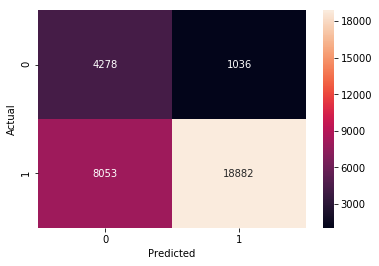

In [45]:
#report on train data
report(d_train_tf_wt,y_train,dt_tf_wt)

              precision    recall  f1-score   support

           0       0.32      0.73      0.44      2278
           1       0.93      0.69      0.79     11544

   micro avg       0.69      0.69      0.69     13822
   macro avg       0.62      0.71      0.62     13822
weighted avg       0.83      0.69      0.73     13822


The value of TPR is 0.687
The value of TNR is 0.731
The value of FPR is 0.269
The value of FNR is 0.313

The roc auc score is 0.784996


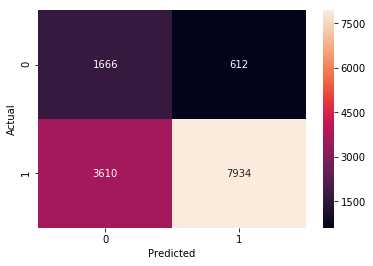

In [46]:
#report on test data
report(d_test_tf_wt,y_test,dt_tf_wt)

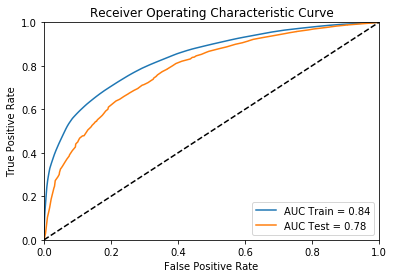

In [47]:
#plot roc curve for train and test data
plotROC(d_train_tf_wt,y_train,d_test_tf_wt,y_test,dt_tf_wt)

## Adding Review Summary To the Reviews as a Feature

In [73]:
listA = [preprocessed_summary[i] +" " + preprocessed_reviews[i] for i in range(len(preprocessed_reviews))]
dwA_train,dwA_test,y_train,y_test=ms.train_test_split(listA, y, stratify=y, test_size=0.3, random_state=0)

In [74]:
trainA_list=[]
for sent in dwA_train:
    trainA_list.append(sent.split())
w2vA_model=Word2Vec(trainA_list,min_count=5,size=50, workers=4)
print(w2vA_model.wv.most_similar('great'))
print('='*50)
print(w2vA_model.wv.most_similar('worst'))
w2vA_words = list(w2vA_model.wv.vocab)

[('awesome', 0.8678628206253052), ('fantastic', 0.7926838397979736), ('excellent', 0.7768711447715759), ('terrific', 0.7677218317985535), ('good', 0.7663905024528503), ('wonderful', 0.7530331611633301), ('amazing', 0.700322687625885), ('perfect', 0.6781115531921387), ('fabulous', 0.6276552677154541), ('decent', 0.619789719581604)]
[('best', 0.7559400200843811), ('nastiest', 0.7507145404815674), ('greatest', 0.7495577335357666), ('tasted', 0.6673142910003662), ('eaten', 0.6463392376899719), ('closest', 0.642666220664978), ('tastiest', 0.6232167482376099), ('experienced', 0.6199864745140076), ('awful', 0.6144534945487976), ('ive', 0.6056485772132874)]


In [75]:
# average Word2Vec
# compute average word2vec for each review in train dataset.
#train dataset
d_trainA_w2 = [];
for sent in tqdm(trainA_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2vA_words:
            vec = w2vA_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        else:
            sent_vec+=0
    if cnt_words != 0:
        sent_vec /= cnt_words
    d_trainA_w2.append(sent_vec)
print(len(d_trainA_w2))
print(len(d_trainA_w2[0]))

100%|██████████| 32249/32249 [00:59<00:00, 539.51it/s]

32249
50


In [76]:
# average Word2Vec
# compute average word2vec for each review in train dataset.
#test dataset
testA_list=[]
for sent in dwA_test:
    testA_list.append(sent.split())
d_testA_w2 = [];
for sent in tqdm(testA_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2vA_words:
            vec = w2vA_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        else:
            sent_vec+=0
    if cnt_words != 0:
        sent_vec /= cnt_words
    d_testA_w2.append(sent_vec)
print(len(d_testA_w2))
print(len(d_testA_w2[0]))

100%|██████████| 13822/13822 [00:26<00:00, 520.21it/s]

13822
50


In [77]:
# Please write all the code with proper documentation
omdA_w2,omssA_w2 = cv_DT(d_trainA_w2, y_train)

Time elapsed : 193.38 Seconds
 optimal alpha using Grid Search is {'max_depth': 10, 'min_samples_split': 500}


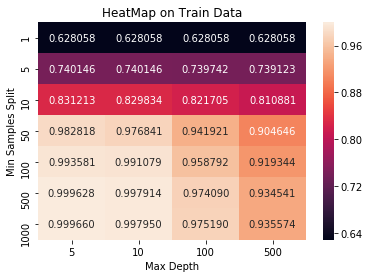

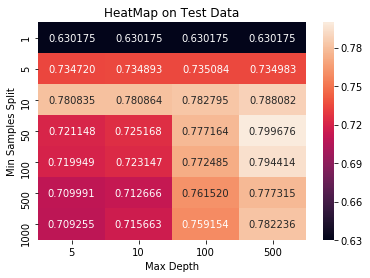

In [78]:
#plot heatmap on train and test data
plotHeatMap(d_trainA_w2,y_train,d_testA_w2,y_test)

In [79]:
#model with optimal max_depth and optimal min_samples_split
dt_A_w2=DecisionTreeClassifier(max_depth= omdA_w2 , min_samples_split = omssA_w2,class_weight='balanced')
dt_A_w2.fit(d_trainA_w2,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

              precision    recall  f1-score   support

           0       0.39      0.85      0.54      5314
           1       0.96      0.74      0.84     26935

   micro avg       0.76      0.76      0.76     32249
   macro avg       0.68      0.80      0.69     32249
weighted avg       0.87      0.76      0.79     32249


The value of TPR is 0.740
The value of TNR is 0.852
The value of FPR is 0.148
The value of FNR is 0.260

The roc auc score is 0.883713


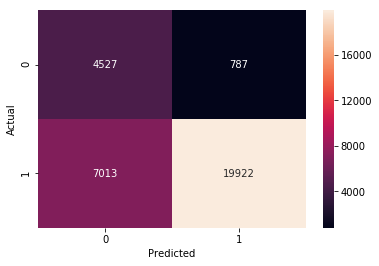

In [80]:
#report on train data
report(d_trainA_w2,y_train,dt_A_w2)

              precision    recall  f1-score   support

           0       0.36      0.79      0.50      2278
           1       0.95      0.72      0.82     11544

   micro avg       0.73      0.73      0.73     13822
   macro avg       0.65      0.76      0.66     13822
weighted avg       0.85      0.73      0.77     13822


The value of TPR is 0.723
The value of TNR is 0.794
The value of FPR is 0.206
The value of FNR is 0.277

The roc auc score is 0.842654


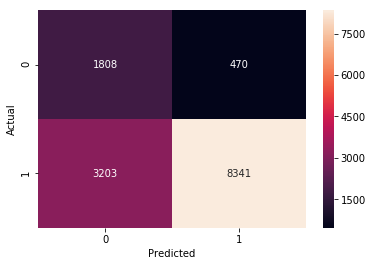

In [81]:
#report on test data
report(d_testA_w2,y_test,dt_A_w2)

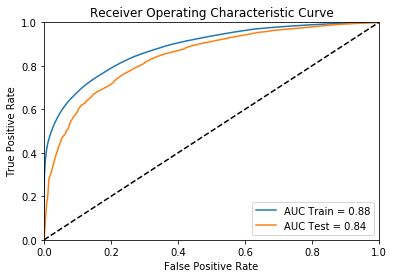

In [82]:
#plot roc curve for train and test data
plotROC(d_trainA_w2,y_train,d_testA_w2,y_test,dt_A_w2)

# [6] Conclusions

In [48]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
pt = PrettyTable()

pt.field_names = ["Vectorising Method","Max Depth", "Min Samples Split", "AUC Score","Precision", "Recall", "F1-Score"]

pt.add_row(["Bag Of Words",50, 500 , 0.795, 0.84, 0.74, 0.77 ])
pt.add_row(["Tf-Idf",50, 500, 0.803, 0.84, 0.74, 0.77 ])
pt.add_row(["AV-W2V",10, 500, 0.831, 0.85, 0.74, 0.77 ])
pt.add_row(["TfIdf-W2V",10, 500, 0.784, 0.83, 0.69, 0.73 ])
pt.add_row(["","","","","","",""])
pt.add_row(["Rev+Des with AV-W2V",10, 500, 0.842, 0.85, 0.73, 0.77 ])


print(pt)
print("\n\n Note: Auc Score, Precision, Recall and F1- Score are on Test Data")

+---------------------+-----------+-------------------+-----------+-----------+--------+----------+
|  Vectorising Method | Max Depth | Min Samples Split | AUC Score | Precision | Recall | F1-Score |
+---------------------+-----------+-------------------+-----------+-----------+--------+----------+
|     Bag Of Words    |     50    |        500        |   0.795   |    0.84   |  0.74  |   0.77   |
|        Tf-Idf       |     50    |        500        |   0.803   |    0.84   |  0.74  |   0.77   |
|        AV-W2V       |     10    |        500        |   0.831   |    0.85   |  0.74  |   0.77   |
|      TfIdf-W2V      |     10    |        500        |   0.784   |    0.83   |  0.69  |   0.73   |
|                     |           |                   |           |           |        |          |
| Rev+Des with AV-W2V |     10    |        500        |   0.842   |    0.85   |  0.73  |   0.77   |
+---------------------+-----------+-------------------+-----------+-----------+--------+----------+


1) The highest AUC score is achieved after vectorization of reviews using *Average Word2Vec* method. The AUC score is 0.831.

2) The best value of max_depth and min_samples_split, the hyperparameters, remains same from grid search and from the heatmaps on train and test datasets.

3) Top 20 most important features are completely different between Bag of Words and Tf-Idf.

4) The lowest ROC-AUC score is achieved after vectorization by *Tf-Idf weighted Word2Vec*. The score is 0.784.

5) We can say that model is descent in predicting positive reviews looking at the Precision, Recall and F1-score.

6) The AUC score for Average W2V featurization increased by 1.3% after adding the summary as a feature.

7) If we look at the tree image, model trained after vectorization from bag of words and tf-idf, the root node and the first node is same in both the cases.